In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)

from collections import Counter
from html import unescape
import scipy
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF

We'll take the [20 newsgroups](http://qwone.com/~jason/20Newsgroups/) dataset and extract their main topics using three data extraction methods:

- Latent Semantic Analysis (LSA)
- Latent Dirichlet Allocation (LDA)
- Non-Negative Matrix Factorization (NNMF)

The goal is to determine which method, if any, best reproduces the topics represented by the newsgroups.

#### Importing the data set
The data set consists of multiple txt files. We'll walk the file directories and import all text data into a data frame.

In [2]:
# instantiate the root directory where all txt files are located
rootdir = '/Users/Badran/Downloads/20news-18828/'

# create an empty data frame with the right column names
df = pd.DataFrame(columns=['newsgroup', 'article','text'])

# walk the root directory and extract the data
for root, dirs, files in os.walk(rootdir):
    for subdir in dirs:
        for subroot, subdirs, files in os.walk(rootdir+subdir):
            temp_df = pd.DataFrame(columns=['newsgroup','article','text'])
            print(subdir)
            for i, filename in enumerate(files):
                filepath = os.path.join(rootdir,subdir,filename)
                with open(filepath, 'rb') as f:
                    f_content = f.read()
                    temp_df.loc[i, 'article'] = filename
                    temp_df.loc[i, 'newsgroup'] = subdir
                    temp_df.loc[i, 'text'] = f_content.decode('latin1')
            df = df.append(temp_df, ignore_index=True)

talk.politics.mideast
rec.autos
comp.sys.mac.hardware
alt.atheism
rec.sport.baseball
comp.os.ms-windows.misc
rec.sport.hockey
sci.crypt
sci.med
talk.politics.misc
rec.motorcycles
comp.windows.x
comp.graphics
comp.sys.ibm.pc.hardware
sci.electronics
talk.politics.guns
sci.space
soc.religion.christian
misc.forsale
talk.religion.misc


### Parsing the data into a tf-idf matrix
We'll use a sense-2-vec approach and create a tf-idf matrix incorporating parts of speech information. To do so, we'll create two custom functions and use them with Sklearn's TFIDF vectorizer.

In [4]:
articles = df.copy()

In [5]:
#articles.text = articles.text.replace(r'>|<|\||\t', ' ', regex=True)
# remove whitespace and e-mail characters, and convert to lowercase
articles.text = articles.text.apply(lambda x: ' '.join(x.split())).str.lower()
import string
articles['preprocessed'] = articles.text.str.replace('[{}]'.format(string.punctuation), '')

In [6]:
articles.head(2)

,newsgroup,article,text,preprocessed
0,talk.politics.mideast,75895,"from: hm@cs.brown.edu (harry mamaysky) subject: heil hernlem in article <1993apr14.125813.21737@ncsu.edu> hernlem@chess.ncsu.edu (brad hernlem) writes: lebanese resistance forces detonated a bomb under an israeli occupation patrol in lebanese territory two days ago. three soldiers were killed and two wounded. in ""retaliation"", israeli and israeli-backed forces wounded 8 civilians by bombarding several lebanese villages. ironically, the israeli government justifies its occupation in lebanon by claiming that it is necessary to prevent such bombardments of israeli villages!! congratulations to the brave men of the lebanese resistance! with every israeli son that you place in the grave you are underlining the moral bankruptcy of israel's occupation and drawing attention to the israeli government's policy of reckless disregard for civilian life. brad hernlem (hernlem@chess.ncsu.edu) very nice. three people are murdered, and bradly is overjoyed. when i hear about deaths in the middle east, be it jewish or arab deaths, i feel sadness, and only hope that soon this all stops. apparently, my view point is not acceptable to people like you bradly. hernlem, you disgust me. harry.",from hmcsbrownedu harry mamaysky subject heil hernlem in article 1993apr1412581321737ncsuedu hernlemchessncsuedu brad hernlem writes lebanese resistance forces detonated a bomb under an israeli occupation patrol in lebanese territory two days ago three soldiers were killed and two wounded in retaliation israeli and israelibacked forces wounded 8 civilians by bombarding several lebanese villages ironically the israeli government justifies its occupation in lebanon by claiming that it is necessary to prevent such bombardments of israeli villages congratulations to the brave men of the lebanese resistance with every israeli son that you place in the grave you are underlining the moral bankruptcy of israels occupation and drawing attention to the israeli governments policy of reckless disregard for civilian life brad hernlem hernlemchessncsuedu very nice three people are murdered and bradly is overjoyed when i hear about deaths in the middle east be it jewish or arab deaths i feel sadness and only hope that soon this all stops apparently my view point is not acceptable to people like you bradly hernlem you disgust me harry
1,talk.politics.mideast,76248,"from: waldo@cybernet.cse.fau.edu (todd j. dicker) subject: re: israel's expansion ii ab4z@virginia.edu (""andi beyer"") writes: > first of all i never said the holocaust. i said before the > holocaust. i'm not ignorant of the holocaust and know more > about nazi germany than most people (maybe including you). uh oh! the first sign of an argument without merit--the stating of one's ""qualifications"" in an area. if you know something about nazi germany, show it. if you don't, shut up. simple as that. > i don't think the suffering of some jews during wwii > justifies the crimes commited by the israeli government. any > attempt to call civil liberterians like myself anti-semetic is > not appreciated. all jews suffered during wwii, not just our beloved who perished or were tortured. we all suffered. second, the name-calling was directed against you, not civil-libertarians in general. your name-dropping of a fancy sounding political term is yet another attempt to ""cite qualifications"" in order to obfuscate your glaring unpreparedness for this argument. go back to the minors, junior.",from waldocybernetcsefauedu todd j dicker subject re israels expansion ii ab4zvirginiaedu andi beyer writes first of all i never said the holocaust i said before the holocaust im not ignorant of the holocaust and know more about nazi germany than most people maybe including you uh oh the first sign of an argument without meritthe stating of ones qualifications in an area if you know something about nazi germany show it if you dont shut up simple as that i dont think the s

In [7]:
# instantiate the SpaCy module
nlp = spacy.load('en')

# custom tokenizing function
def my_tokenizer(doc):
    tokens = nlp(doc)
    return([token.lemma_ for token in tokens
            if not token.is_punct
            and not token.is_stop
            and not len(token.text) == 1
            and (token.pos_=='NOUN' or token.pos_=='ADJ' or token.pos_=='VERB')])

# create a dataframe from a word matrix
def matrix2df(word_matrix, feat_names):
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(word_matrix)]
    df = pd.DataFrame(data=word_matrix.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)

custom_vec = TfidfVectorizer(tokenizer=my_tokenizer,
                             max_df=.7, # drop words that occur in more than 70% of the paragraphs
                             min_df=5, # only use words that appear at least five times
                             stop_words='english',
                             use_idf=True,# we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', # longer and shorter paragraphs get treated equally
                             smooth_idf=True) #Prevents divide-by-zero errors



tfidf_matrix = custom_vec.fit_transform(articles.preprocessed)
tokens = custom_vec.get_feature_names()
articles_tfidf = matrix2df(tfidf_matrix, tokens)

In [29]:
# Number of topics.
ntopics = 5

# Linking words to topics
def word_topic(tfidf, solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic = tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components = pd.DataFrame(words_by_topic, index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index = np.repeat(n_topics, n_top_words, axis=0)
    topwords = pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords = components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen = sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist = chosen.index + " " + round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10

### LSA

In [30]:
svd = TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
articles_lsa = lsa.fit_transform(tfidf_matrix)

In [31]:
components_lsa = word_topic(tfidf_matrix, articles_lsa, tokens)

topwords = pd.DataFrame()

topwords['LSA'] = top_words(components_lsa, n_top_words)

In [32]:
lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

articles_lda = lda.fit_transform(tfidf_matrix)

components_lda = word_topic(tfidf_matrix, articles_lda, tokens)

topwords['LDA'] = top_words(components_lda, n_top_words)

/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [33]:
# NNMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
articles_nmf = nmf.fit_transform(tfidf_matrix) 

components_nmf = word_topic(tfidf_matrix, articles_nmf, tokens)

topwords['NNMF']=top_words(components_nmf, n_top_words)

In [34]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
              LSA            LDA            NNMF
0  write 321.44    write 14.31    people 8.97   
0  article 268.59  article 11.73  god 8.59      
0  know 246.73     know 11.32     write 8.05    
0  good 229.01     window 11.09   article 6.79  
0  think 212.07    thank 10.08    think 6.61    
0  people 205.35   good 9.71      know 6.22     
0  time 176.33     file 8.3       say 5.79      
0  want 166.04     think 8.17     good 5.51     
0  use 165.4       use 8.14       believe 5.12  
0  work 163.47     need 7.64      christian 5.11
Topic 1:
             LSA             LDA          NNMF
1  window 122.98  write 326.02    window 17.64
1  file 82.99     article 266.21  file 11.2   
1  card 80.66     know 257.43     program 6.91
1  thank 79.86    good 240.85     run 5.63    
1  drive 62.12    think 222.58    thank 5.45  
1  email 59.83    people 220.53   use 5.05    
1  driver 57.65   time 185.11     problem 4.77
1  program 55.94  window 183.38   help 4.66   
1  disk 49.33     us

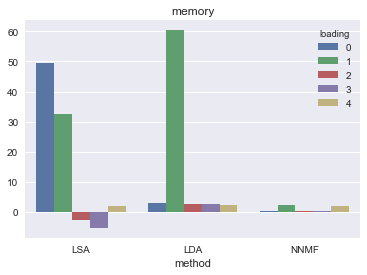

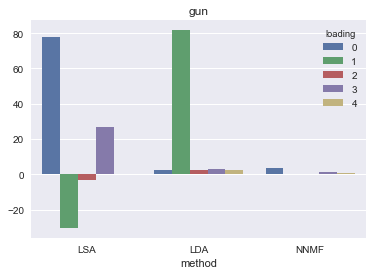

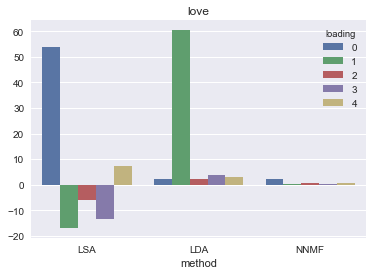

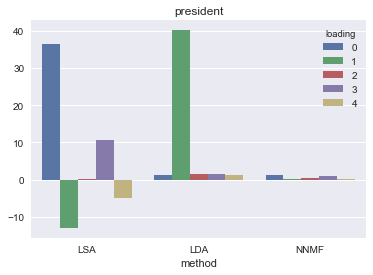

In [37]:
# The words to look at.
targetwords=['memory','gun','love','president']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()

### Conclusion
LSA and NNMF had a very similar performance and were able to detect all topics fairly well.

LDA repeated the terms *write, article, know, good, think, and thank* in all topics. This is because the documents in the data set almost always start with e-mail headings with those terms. Decreasing the value in the"max_df" parameter in TfidfVectorizer may be helpful to discard these words that appear too often.